# Developing FEM in 2D

Copyright (C) 2010-2020 Luke Olson<br>
Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>

-----

In this note, we look at constructing a finite element approximation to
$$
\begin{align*}
{}- \nabla\cdot \kappa(x,y) \nabla &u = f(x,y)\qquad((x,y)\in\Omega),\\
u &= g(x,y)\qquad ((x,y)\in \partial \Omega).
\end{align*}
$$
We define $\kappa$, $f$, and $g$ in a bit.

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Mesh the Domain

This uses [meshpy](https://documen.tician.de/meshpy/), which under the hood uses [Triangle](https://www.cs.cmu.edu/~quake/triangle.html).

`pip install meshpy` to install.

NB: Triangle is *not* open-source software. If you are looking for a quality mesher that is open-source (but a bit more complex to use), look at [Gmsh](http://gmsh.info/).

In [2]:
import meshpy.triangle as triangle

def round_trip_connect(start, end):
    return [(i, i+1) for i in range(start, end)] + [(end, start)]

def make_mesh():
    points = [(-1, -1), (1, -1), (1, 1), (-1, 1)]
    facets = round_trip_connect(0, len(points)-1)

    circ_start = len(points)
    points.extend(
            (0.25 * np.cos(angle), 0.25 * np.sin(angle))
            for angle in np.linspace(0, 2*np.pi, 30, endpoint=False))

    facets.extend(round_trip_connect(circ_start, len(points)-1))

    def needs_refinement(vertices, area):
        bary = np.sum(np.array(vertices), axis=0)/3
        max_area = 0.01 + la.norm(bary, np.inf)*0.01
        return bool(area > max_area)

    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_facets(facets)

    built_mesh = triangle.build(info, refinement_func=needs_refinement)
    return np.array(built_mesh.points), np.array(built_mesh.elements)

V, E = make_mesh()

In [3]:
nv = len(V)
ne = len(E)
print(V.shape)
print(E.shape)
print(E.max())
X, Y = V[:, 0], V[:, 1]

(239, 2)
(441, 3)
238


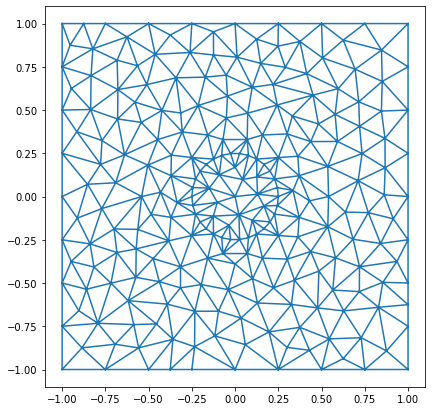

In [4]:
plt.figure(figsize=(7,7))
plt.gca().set_aspect("equal")
plt.triplot(X, Y, E)

## Constructing Element Mappings

Map the reference triangle to the triangle given by these vertices:

In [5]:
v1 = np.array([1.0, 1.0])
v2 = np.array([3.0, 1.0])
v3 = np.array([2.0, 2.0])

Come up with the matrix `TA` and vector `Tb` of the affine mapping.

In [6]:
#clear
TA = np.array([v2-v1, v3-v1]).T
Tb = v1

Test the mapping.

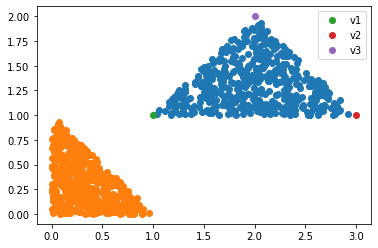

In [7]:
# make random points in the reference triangle
r = np.random.rand(1000, 2)
r = r[r[:, 0]+r[:, 1] < 1]

x = np.einsum("ij,pj->pi", TA, r) + Tb

plt.plot(x[:, 0], x[:, 1], "o")
plt.plot(r[:, 0], r[:, 1], "o")
plt.plot(v1[0], v1[1], "o", label="v1")
plt.plot(v2[0], v2[1], "o", label="v2")
plt.plot(v3[0], v3[1], "o", label="v3")
plt.legend()

## Problem Data

Define $\kappa$, $f$, and $g$.

In [8]:
def kappa(xvec):
    x, y = xvec
    if (x**2 + y**2)**0.5 <= 0.25:
        return 25.0
    else:
        return 1.0

def f(xvec):
    x, y = xvec
    if (x**2 + y**2)**0.5 <= 0.25:
        return 100.0
    else:
        return 0.0

    
def g(xvec):
    x, y = xvec
    return 1 * (1 - x**2)    

## Assembly Helper

In [9]:
class MatrixBuilder:
    def __init__(self):
        self.rows = []
        self.cols = []
        self.vals = []
        
    def add(self, rows, cols, submat):
        for i, ri in enumerate(rows):
            for j, cj in enumerate(cols):
                self.rows.append(ri)
                self.cols.append(cj)
                self.vals.append(submat[i, j])
                
    def coo_matrix(self):
        return sparse.coo_matrix((self.vals, (self.rows, self.cols)))

## Assembly

Recall the nodal linear basis:
- $\varphi_1(r,s) =1-r-s$
- $\varphi_2(r,s) =r$
- $\varphi_3(r,s) =s$

Create a $2\times N_p$ array containing $\nabla_{\boldsymbol r} \varphi_i$.

In [10]:
#clear
dbasis = np.array([
    [-1, 1, 0],
    [-1, 0, 1]])

Assemble the matrix. Use a `MatrixBuilder` `a_builder`. Recall (from the notes):
$$
  \let\b=\boldsymbol
  \int_{E} \kappa(\b{x}) \nabla \varphi_i ( \b{x} )^T \nabla \varphi_j ( \b{x} ) d\b{x}
   = ( J_T^{-T} \nabla_{\b r} \varphi_i )^T ( J_T^{-T} \nabla_{\b r} \varphi_j ) | J_T | \int_{\hat E} \kappa( T( \b{r} ) ) d\b{r}
$$

Using a 1-point Gauss Quadrature rule:
$\int_{\hat E} f \approx \frac 12  f(\bar{\boldsymbol x})$,
where $\bar{\boldsymbol x}$ is the element centroid.

In [11]:
#clear
a_builder = MatrixBuilder()

for ei in range(0, ne):
    vert_indices = E[ei, :]
    x0, x1, x2 = el_verts = V[vert_indices]
    centroid = np.mean(el_verts, axis=0)

    J = np.array([x1-x0, x2-x0]).T
    invJT = la.inv(J.T)
    detJ = la.det(J)
    dphi = invJT @ dbasis

    Aelem = kappa(centroid) * (detJ / 2.0) * dphi.T @ dphi

    a_builder.add(vert_indices, vert_indices, Aelem)

In [16]:
idx = list(zip(a_builder.rows, a_builder.cols))
seen = set()
dupes = [x for x in idx if x in seen or seen.add(x)] 
print(len(idx))
print(len(dupes)) #Many duplicate entries

3969
2372


Eliminate duplicate entries in the COO-form sparse matrix:

In [12]:
A = a_builder.coo_matrix().tocsr().tocoo() #Duplicate entries will be summed together

Compute the right-hand side `b` using a 1-point Gauss Quadrature rule:
$$
\int_{E_i} f(\boldsymbol x) \phi_i\,d\boldsymbol x
= |J| \int_{E} f(T_i(\boldsymbol r)) \phi_i(\alpha)\,d\boldsymbol r\\
\approx \frac 12 |J|   f(\bar{\boldsymbol x}) \phi_i(\boldsymbol r)
= \frac 16 |J| f(\bar{\boldsymbol x}),
$$
where $\bar{\boldsymbol x}$ is the element centroid.

In [13]:
#clear
b = np.zeros(nv)

for ei in range(0, ne):
    vert_indices = E[ei, :]
    x0, x1, x2 = el_verts = V[vert_indices]
    centroid = np.mean(el_verts, axis=0)

    J = np.array([x1-x0, x2-x0]).T
    detJ = la.det(J)

    belem = f(centroid) * (detJ / 6.0) * np.ones((3,))

    for i, vi in enumerate(vert_indices):
        b[vi] += belem[i]

## Boundary Conditions

Create flags for the boundary vertices/DoFs:

In [14]:
tol = 1e-12
is_boundary = (
    (np.abs(X+1) < tol)
    | (np.abs(X-1) < tol)
    | (np.abs(Y+1) < tol)
    | (np.abs(Y-1) < tol))
is_g_boundary = np.abs(Y+1) < tol

Next, construct the 'volume-lifted' boundary condition $u^0$.

In [15]:
#clear
u0 = np.zeros(nv)
u0[is_g_boundary] = g(V[is_g_boundary].T)

Compute the "post-lifting" right hand side `rhs`.

*Note:* The Riesz representer of `rhs` needs to be in $H^1_0$. (I.e. what should its values for the boundary DoFs be?)

In [16]:
#clear
rhs = b - A @ u0

rhs[is_boundary] = 0.0

Next, set the rows corresponding to boundary DoFs to be identity rows:

In [17]:
#clear
for k in range(A.nnz):
    i = A.row[k]
    j = A.col[k]
    if is_boundary[i]:
        A.data[k] = 1 if i == j else 0

## Solve and Plot

Now solve and correct for lifting:

In [18]:
#clear
uhat = sla.spsolve(A.tocsr(), rhs)

u = uhat + u0

And plot:

/tmp/ipykernel_39743/2828084510.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection='3d')


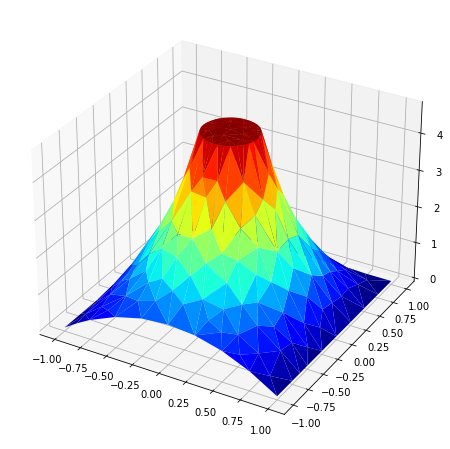

In [19]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca(projection='3d')
ax.plot_trisurf(X, Y, u, triangles=E, cmap=plt.cm.jet, linewidth=0.2)
plt.show()